<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b> Комментарий ревьюера</b>
    
    
Привет! Меня зовут Даниил Вяжев, я буду проверять твой проект. Если не против, давай общаться на «ты». Если тебе такой стиль общения не нравится, напиши об этом, будем на «вы».

Сразу хочу обратить внимание на цветовую разметку:

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Зеленым с пометкой ✔️ отмечены отличные решения и идеи, которые можно и нужно использовать в будущем.
</div>
    
<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Желтым с пометкой ⚠️ отмечено то, что можно или нужно оптимизировать, в зависимости от контекста.</div>    
    
<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Красным с пометкой ❌ обозначены пропущенные пункты задания и ошибки, которые обязательно надо будет исправить, чтобы результаты были верные.</div> 
    
**Ответы на мои комментарии или доработки по моим рекомендациям попрошу выделить каким-нибудь цветом, кроме перечисленных.**
Также я попрошу тебя **не менять, не передвигать и не удалять мои комментарии**, чтобы при последующей проверке мне было проще ориентироваться.
        
<hr>
    
<font color= 'dodgerblue'>**По проекту:**</font> 
    
    
Поздравляю тебя с успешным завершением работы над этим этапом проекта!
    
Ты создала полноценный пайплайн рекомендательной системы production-уровня. Я увидел понимание важных аспектов работы с большими данными от эффективного управления памятью через правильные типы данных и ленивую загрузку до алгоритмических оптимизаций с использованием argpartition и битовой упаковки. Отметил правильный баланс между производительностью и читаемостью кода, это похвально. 
    
Единственная существенная проблема - утечка данных при создании признаков. Продолжай в том же духе!
    
<hr style="border-top: 3px solid purple; "></hr>
Комментарии можешь оставлять с помощью такого кода в Markdown ячейке:
    
    
    <div class="alert alert-info">
    <h2> Комментарий студента</h2>


    Тут текст.
    </div>
    
    
    <font color='red'> Этот код позволяет менять цвет текста. </font>     


  

О том, как **форматировать текст** в Markdown ячейке или как добавлять ссылки, ты можешь узнать [тут](https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet) и [вот тут](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd).




Желаю удачи!


<img src="https://user-images.githubusercontent.com/74038190/225813708-98b745f2-7d22-48cf-9150-083f1b00d6c9.gif" width="500">
</div>    



# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [ ]:
import os
import gc
import json 
from pathlib import Path
from functools import lru_cache
from typing import Iterator, Iterable, Optional, Sequence

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import boto3
from boto3.s3.transfer import TransferConfig, S3UploadFailedError
from botocore.exceptions import ClientError
from lightgbm import LGBMRanker

import psutil
from tqdm import tqdm

import pyarrow as pa
import pyarrow.parquet as pq

from scipy.sparse import coo_matrix
from implicit.cpu.als import AlternatingLeastSquares


import lightgbm as lgb
from dotenv import load_dotenv

from config import CFG, RNG
import logging

logging.basicConfig(
    level=CFG.LOG_LEVEL,
    format="%(asctime)s | %(levelname)-7s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)

load_dotenv()

/home/mle-user/mle_projects/mle-project-sprint-4-v001/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# small utils

def ram_gb() -> float:
    return float(psutil.virtual_memory().available / 1024**3)

def ensure_dir(path: Path | str) -> None:
    Path(path).mkdir(parents=True, exist_ok=True)

def require_env(name: str) -> str:
    value = os.getenv(name)
    if not value:
        raise RuntimeError(f"missing required env variable: {name}")
    return value

def read_parquet(path: Path | str) -> pd.DataFrame:
    return pd.read_parquet(path)

def read_parquet_lazy(
    path: Path | str,
    *,
    columns: Optional[list[str]] = None,
    batch_size: int = 200_000,
) -> Iterator[pd.DataFrame]:
    with pa.OSFile(str(path), "rb") as file_handle:
        parquet_file = pq.ParquetFile(file_handle)
        for record_batch in parquet_file.iter_batches(columns=columns, batch_size=batch_size):
            batch_df = record_batch.to_pandas(ignore_metadata=True)
            if not batch_df.empty:
                yield batch_df

def iter_tables(data: pd.DataFrame | pa.Table | Iterable[pd.DataFrame | pa.Table]) -> Iterator[pa.Table]:
    if isinstance(data, (pd.DataFrame, pa.Table)):
        data = [data]
    for batch in data:
        if isinstance(batch, pd.DataFrame):
            if not batch.empty:
                yield pa.Table.from_pandas(batch, preserve_index=False)
        elif isinstance(batch, pa.Table):
            if batch.num_rows:
                yield batch
        else:
            raise TypeError(f"unsupported batch type: {type(batch)!r}")

def same_schema(a: pa.Schema, b: pa.Schema) -> bool:
    return len(a) == len(b) and all(
        af.name == bf.name and af.nullable == bf.nullable and af.type.equals(bf.type)
        for af, bf in zip(a, b)
    )

def save_parquet(
    data: pd.DataFrame | pa.Table | Iterable[pd.DataFrame | pa.Table],
    path: Path | str,
    *,
    row_group_size: int = 1_000_000,
) -> Path:
    path = Path(path)
    ensure_dir(path.parent)

    tables_iter = iter(iter_tables(data))
    first_table = next(tables_iter, None)
    if first_table is None:
        raise ValueError(f"nothing to write: {path}")

    schema = first_table.schema
    with pq.ParquetWriter(str(path), schema, compression="snappy") as writer:
        writer.write_table(first_table, row_group_size=row_group_size)
        for table in tables_iter:
            if not same_schema(table.schema, schema):
                raise ValueError("schema mismatch (name/type/nullable differ)")
            writer.write_table(table, row_group_size=row_group_size)

    return path

def pack_u64(user_ids_u32: np.ndarray, track_ids_u32: np.ndarray) -> np.ndarray:
    return (user_ids_u32.astype(np.uint64, copy=False) << 32) | track_ids_u32.astype(np.uint64, copy=False)

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Если на вход подается пустой итератор, функция создаст пустой файл без схемы.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Правильный паттерн для работы с огромными датасетами без перегрузки памяти.



<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
В функции read_parquet_lazy не закрывается ParquetFile, это может привести к утечке ресурсов.

<div class="alert alert-info" role="alert" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий студента </b>
    
Добавила контекстный менеджер для закрытия файлового дескриптора в read_parquet_lazy. </hr>
Пустые батчи пропускаются, а если после фильтрации нечего записывать, функция падает. </hr>
Схема фиксируется по первому непустому батчу и далее проверяется совпадение полей и их порядок.

</div>

In [45]:
# S3 utils

_s3_transfer_config = TransferConfig(
    multipart_threshold=8 * 1024 * 1024,
    multipart_chunksize=64 * 1024 * 1024,
    max_concurrency=10,
    use_threads=True,
)

@lru_cache(maxsize=1)
def get_s3_client():
    endpoint_url = os.environ.get("S3_ENDPOINT_URL")
    return boto3.client("s3", endpoint_url=endpoint_url)

def make_s3_key(prefix: str, filename: str) -> str:
    return f"{prefix.rstrip('/')}/{filename}"

def upload_to_s3(local_path: Path, key: str, *, show_progress: bool = True) -> str:
    bucket_name = require_env("S3_BUCKET_NAME")
    normalized_key = key.lstrip("/")

    class ProgressPercentage:
        def __init__(self, filename: Path):
            self._size = filename.stat().st_size
            self._seen = 0
            self._pbar = tqdm(total=self._size, unit="B", unit_scale=True, desc=f"uploading {filename.name}")

        def __call__(self, bytes_amount: int):
            self._seen += bytes_amount
            self._pbar.update(bytes_amount)

        def __del__(self):
            self._pbar.close()

    callback = ProgressPercentage(local_path) if show_progress else None

    try:
        get_s3_client().upload_file(
            Filename=str(local_path),
            Bucket=bucket_name,
            Key=normalized_key,
            ExtraArgs={},
            Callback=callback,
            Config=_s3_transfer_config,
        )
        response = get_s3_client().head_object(Bucket=bucket_name, Key=normalized_key)
        print(f"{local_path} uploaded, size: {response['ContentLength']} bytes")
        return f"s3://{bucket_name}/{normalized_key}"

    except Exception as e:
        error_code = getattr(e, "response", None)
        error_code = ((error_code or {}).get("Error") or {}).get("Code")
        is_bucket_full = (error_code == "BucketMaxSizeExceeded") or ("BucketMaxSizeExceeded" in str(e))

        if is_bucket_full:
            print(f"S3 skip, bucket full: {local_path} -> {normalized_key}")
            return f"file://{local_path}"

        raise

def download_from_s3(key: str, local_path: Path, *, min_bytes: int = 1) -> Path:
    bucket_name = require_env("S3_BUCKET_NAME")
    normalized_key = key.lstrip("/")
    ensure_dir(local_path.parent)
    get_s3_client().download_file(bucket_name, normalized_key, str(local_path))
    if local_path.stat().st_size < min_bytes:
        raise RuntimeError(f"file too small: {local_path}")
    return local_path

def read_cached_or_download(filename: str, s3_prefix: str) -> pd.DataFrame:
    local_path = CFG.ARTIFACTS_DIR / filename
    if not local_path.exists() or local_path.stat().st_size < 1:
        s3_key = make_s3_key(s3_prefix, filename)
        download_from_s3(s3_key, local_path, min_bytes=1)
    return read_parquet(local_path)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Кастомный callback с tqdm для отображения прогресса загрузки.

In [4]:
# EDA utils
def df_info(df, name: str = "df", dup_subset: Optional[Sequence] = None):
    print(f"\n{'='*3} {name.upper()} {'='*3}")
    print(f"shape: {df.shape[0]:,} x {df.shape[1]}")
    print(f"index: {type(df.index).__name__} | unique={df.index.is_unique} | monotonic={df.index.is_monotonic_increasing}")
    print(f"dtypes: {dict(df.dtypes)}")
    print(f"missing: {df.isna().sum().sum():,} total")
    if dup_subset:
        print(f"duplicates on {list(dup_subset)}: {df.duplicated(subset=list(dup_subset)).sum():,}")
    print()
    display(df.head(5))

In [5]:
def plot_distribution(series, title):
    print(f"\n{title}:")
    print(series.describe(percentiles=CFG.EDA_PERCENTILES))
    plt.figure(figsize=(10, 4))
    plt.hist(series.to_numpy(), bins=CFG.EDA_BINS)
    plt.yscale("log")
    plt.title(title)
    plt.xlabel("count")
    plt.ylabel("frequency (log)")
    plt.show()

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [6]:
print(f"stage 1 | ram: {ram_gb():.2f} gb")

tracks_raw = read_parquet(CFG.RAW_FILES["tracks"])
catalog_names_raw = read_parquet(CFG.RAW_FILES["catalog_names"])
events_raw = read_parquet(CFG.RAW_FILES["events"])

stage 1 | ram: 9.69 gb


In [7]:
if tracks_raw.empty or catalog_names_raw.empty or events_raw.empty:
    raise ValueError("one of raw tables is empty")

schemas = {
    "tracks": (tracks_raw, {"track_id", "artists", "genres"}),
    "catalog_names": (catalog_names_raw, {"type", "id", "name"}),
    "events": (events_raw, {"user_id", "track_id", "started_at"})
}

missing = {name: required - set(df.columns) for name, (df, required) in schemas.items()}

if any(missing.values()):
    parts = [f"{name}={sorted(cols)}" for name, cols in missing.items() if cols]
    raise ValueError(f"missing columns: {' | '.join(parts)}")

null_checks = {
    "tracks_raw.track_id": tracks_raw["track_id"].isna().any(),
    "catalog_names_raw.id": catalog_names_raw["id"].isna().any(),
    "events_raw key columns": events_raw[["user_id", "track_id", "started_at"]].isna().any().any()
}

for field, has_nulls in null_checks.items():
    if has_nulls:
        raise ValueError(f"{field} has nulls")

if not tracks_raw["track_id"].is_unique:
    raise ValueError("tracks_raw.track_id must be unique")
if catalog_names_raw.duplicated(subset=["type", "id"]).any():
    raise ValueError("catalog_names_raw (type, id) must be unique")

integer_fields = [
    (tracks_raw, "track_id", "tracks_raw.track_id"),
    (events_raw, "user_id", "events_raw.user_id"),
    (events_raw, "track_id", "events_raw.track_id")
]

for df, col, name in integer_fields:
    if not pd.api.types.is_integer_dtype(df[col]):
        raise TypeError(f"{name} must be integer")

if not pd.api.types.is_datetime64_any_dtype(events_raw["started_at"]):
    raise TypeError("events_raw.started_at must be datetime")

gc.collect()

0

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [8]:
df_info(events_raw, name="events_raw", dup_subset=["user_id", "track_id", "started_at"])
df_info(tracks_raw, name="tracks_raw", dup_subset=["track_id"])
df_info(catalog_names_raw, name="catalog_names_raw", dup_subset=["type", "id"])


=== EVENTS_RAW ===
shape: 222,629,898 x 4


index: Index | unique=False | monotonic=False
dtypes: {'user_id': dtype('int32'), 'track_id': dtype('int32'), 'track_seq': dtype('int16'), 'started_at': dtype('<M8[ns]')}
missing: 0 total
duplicates on ['user_id', 'track_id', 'started_at']: 0



,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22



=== TRACKS_RAW ===
shape: 1,000,000 x 4
index: RangeIndex | unique=True | monotonic=True
dtypes: {'track_id': dtype('int64'), 'albums': dtype('O'), 'artists': dtype('O'), 'genres': dtype('O')}
missing: 0 total
duplicates on ['track_id']: 0



,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]



=== CATALOG_NAMES_RAW ===
shape: 1,812,471 x 3
index: RangeIndex | unique=True | monotonic=True
dtypes: {'id': dtype('int64'), 'type': dtype('O'), 'name': dtype('O')}
missing: 0 total
duplicates on ['type', 'id']: 0



,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [9]:
valid_tracks_mask = (tracks_raw["artists"].map(len) > 0) & (tracks_raw["genres"].map(len) > 0)

print(f"invalid tracks: {(~valid_tracks_mask).sum():,} ({(~valid_tracks_mask).mean():.2%})")
print(f"events with invalid tracks: {(~events_raw['track_id'].isin(tracks_raw.loc[valid_tracks_mask, 'track_id'])).sum():,} ({(~events_raw['track_id'].isin(tracks_raw.loc[valid_tracks_mask, 'track_id'])).mean():.2%})")
print(f"unknown track_id in events: {(~events_raw['track_id'].isin(tracks_raw['track_id'])).sum():,}")

invalid tracks: 19,023 (1.90%)
events with invalid tracks: 445,449 (0.20%)
unknown track_id in events: 0


In [10]:
known_genres = set(catalog_names_raw.loc[catalog_names_raw["type"] == "genre", "id"])
all_genres = tracks_raw.loc[valid_tracks_mask, "genres"].explode().dropna().astype(np.int64).unique()
missing_genres = [g for g in all_genres if g not in known_genres]

if missing_genres:
    print(f"missing genres: {len(missing_genres)}")
    print(f"examples: {missing_genres[:10]}")

missing genres: 30
examples: [164, 162, 163, 159, 151, 157, 169, 153, 161, 158]


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Правильная обработка пропущенных жанров.

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

- no missing values across `events`, `tracks`, and `catalog_names`
- no key duplicates detected:
    `events` by (user_id, track_id, started_at): 0
    `tracks by` (track_id): 0
    `catalog_names` by (type, id): 0

- `events` index is inconsistent (not unique, not monotonic)
- minor metadata issues in `tracks`: ~1.90% of tracks have empty artists/genres, dropping them would remove only ~0.20% of `events`
- genre dictionary mismatch: `tracks.genres` contains unknown genre IDs (~48k links, 30 unique IDs) missing from `catalog_names`

In [11]:
tracks_clean = tracks_raw.loc[valid_tracks_mask].reset_index(drop=True)
events_clean = events_raw.loc[events_raw["track_id"].isin(tracks_clean["track_id"])].reset_index(drop=True)

catalog_names_clean = catalog_names_raw.copy()
if missing_genres:
    new_genres = pd.DataFrame(
        {"id": missing_genres, "type": "genre", "name": [f"Unknown genre {genre_id}" for genre_id in missing_genres]}
    )
    catalog_names_clean = pd.concat([catalog_names_clean, new_genres], ignore_index=True)

In [12]:
print(f"tracks: {len(tracks_raw):,} -> {len(tracks_clean):,}")
print(f"events: {len(events_raw):,} -> {len(events_clean):,}")
print(f"missing genres added: {len(missing_genres):,}")

tracks: 1,000,000 -> 980,977
events: 222,629,898 -> 222,184,449
missing genres added: 30


In [13]:
del valid_tracks_mask, all_genres, known_genres, missing_genres
del tracks_raw, catalog_names_raw, events_raw
gc.collect()

print(f"stage 1 done | ram: {ram_gb():.2f} gb")

stage 1 done | ram: 16.95 gb


<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Рекомендую добавить валидацию входных данных.

<div class="alert alert-info" role="alert" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий студента </b>

Добавила какую-никакую, но валидацию.

</div>

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [14]:
plays_per_user = events_clean["user_id"].value_counts(sort=False)
plays_per_track = events_clean["track_id"].value_counts(sort=False)


plays per user:
count    1.372767e+06
mean     1.618515e+02
std      3.507933e+02
min      1.000000e+00
50%      5.500000e+01
90%      3.880000e+02
99%      1.574000e+03
max      1.663000e+04
Name: count, dtype: float64


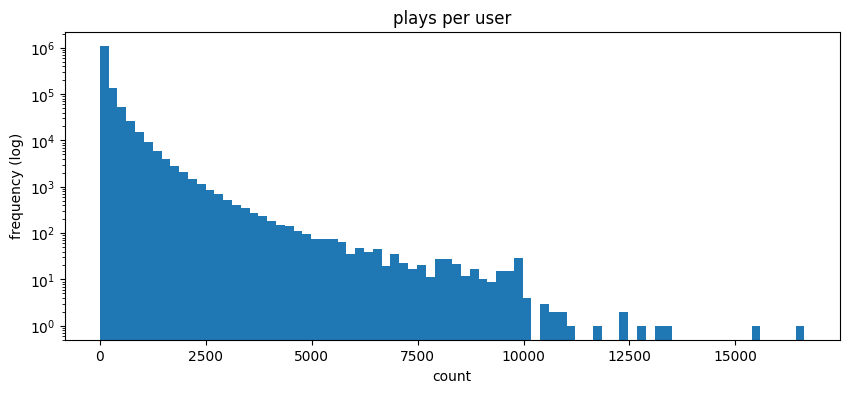


plays per track:
count    980977.000000
mean        226.493026
std        1382.786304
min           5.000000
50%          19.000000
90%         311.000000
99%        3961.000000
max      111062.000000
Name: count, dtype: float64


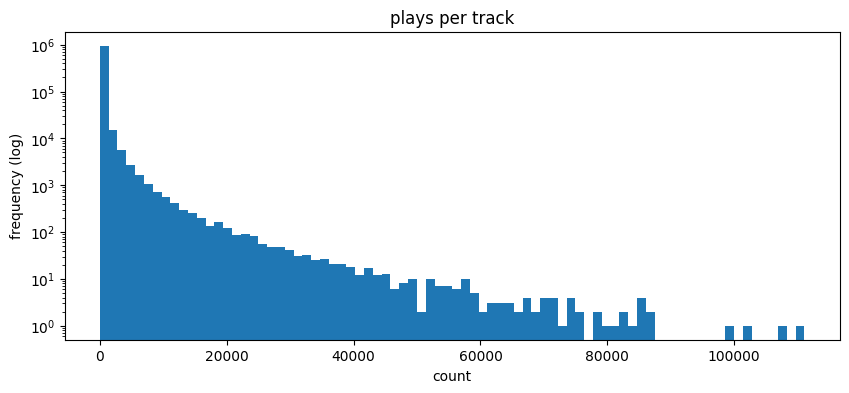

In [15]:
plot_distribution(plays_per_user, "plays per user")
plot_distribution(plays_per_track, "plays per track")

In [16]:
users_count = int(plays_per_user.size)
tracks_count = int(plays_per_track.size)
events_count = int(len(events_clean))
sparsity = 1.0 - (events_count / float(users_count * tracks_count))

print(f"users: {users_count:,}")
print(f"tracks: {tracks_count:,}")
print(f"events: {events_count:,}")
print(f"sparsity: {sparsity:.6f}")

users: 1,372,767
tracks: 980,977
events: 222,184,449
sparsity: 0.999835


Наиболее популярные треки

In [17]:
track_names = (
    catalog_names_clean.loc[catalog_names_clean["type"] == "track", ["id", "name"]]
    .rename(columns={"id": "track_id", "name": "track_name"})
)

top_tracks = (
    plays_per_track.sort_values(ascending=False)
    .head(CFG.TOP_K)
    .rename_axis("track_id")
    .reset_index(name="plays")
    .merge(track_names, on="track_id", how="left")
)

display(top_tracks)

,track_id,plays,track_name
0,53404,111062,Smells Like Teen Spirit
1,33311009,106921,Believer
2,178529,101924,Numb
3,35505245,99490,I Got Love
4,65851540,86670,Юность
5,24692821,86246,Way Down We Go
6,32947997,85886,Shape of You
7,51241318,85244,In The End
8,795836,85042,Shape Of My Heart
9,45499814,84748,Life


Наиболее популярные жанры

In [18]:
genre_names = (
    catalog_names_clean.loc[catalog_names_clean["type"] == "genre", ["id", "name"]]
    .rename(columns={"id": "genre_id", "name": "genre_name"})
)

tracks_genres = tracks_clean[["track_id", "genres"]].explode("genres").rename(columns={"genres": "genre_id"})
tracks_genres["genre_id"] = tracks_genres["genre_id"].astype(np.int64)

track_plays = plays_per_track.rename_axis("track_id").reset_index(name="plays")

top_genres = (
    tracks_genres.merge(track_plays, on="track_id", how="left")
    .groupby("genre_id", sort=False)["plays"].sum()
    .sort_values(ascending=False)
    .head(CFG.TOP_K)
    .rename_axis("genre_id")
    .reset_index(name="plays")
    .merge(genre_names, on="genre_id", how="left")
)

display(top_genres)

,genre_id,plays,genre_name
0,11,55578305,pop
1,75,37799821,rap
2,102,31091989,allrock
3,20,26626234,ruspop
4,3,25303695,rusrap
5,68,20120694,electronics
6,16,16291557,dance
7,2,13166147,rusrock
8,14,12772620,rock
9,47,12437375,metal


Треки, которые никто не прослушал

In [19]:
unheard_count = int((~tracks_clean["track_id"].isin(plays_per_track.index)).sum())
print(f"unheard: {unheard_count:,} ({unheard_count/len(tracks_clean):.2%})")

unheard: 0 (0.00%)


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [ ]:
items_path = save_parquet(tracks_clean, CFG.CLEAN_FILES["items"])
events_path = save_parquet(events_clean, CFG.CLEAN_FILES["events"])
names_path = save_parquet(catalog_names_clean, CFG.CLEAN_FILES["catalog_names"])

upload_to_s3(items_path, make_s3_key(CFG.S3_DATA_PREFIX, CFG.CLEAN_FILES["items"].name))
upload_to_s3(events_path, make_s3_key(CFG.S3_DATA_PREFIX, CFG.CLEAN_FILES["events"].name))
upload_to_s3(names_path, make_s3_key(CFG.S3_DATA_PREFIX, CFG.CLEAN_FILES["catalog_names"].name))

uploading items.parquet:   0%|          | 0.00/18.7M [00:00<?, ?B/s]2026-01-26 17:27:36 | INFO    | Found credentials in environment variables.
uploading items.parquet: 100%|██████████| 18.7M/18.7M [00:01<00:00, 17.7MB/s]


artifacts/items.parquet uploaded, size: 18662970 bytes


uploading events.parquet: 100%|██████████| 1.05G/1.05G [00:13<00:00, 79.8MB/s]


artifacts/events.parquet uploaded, size: 1051924665 bytes


uploading catalog_names.parquet: 100%|██████████| 36.2M/36.2M [00:01<00:00, 22.1MB/s]

artifacts/catalog_names.parquet uploaded, size: 36154922 bytes


's3://s3-student-mle-20250916-5cfbbe83ad-freetrack/recsys/data/catalog_names.parquet'

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [21]:
del tracks_clean, events_clean, catalog_names_clean
del plays_per_user, plays_per_track, track_names, top_tracks, genre_names, tracks_genres, track_plays, top_genres
del items_path, events_path, names_path
gc.collect()

print(f"stage 2 done | ram: {ram_gb():.2f} gb")

stage 2 done | ram: 20.56 gb


# === ЭТАП 3 ===

In [22]:
def pack_u64(user_ids_u32: np.ndarray, track_ids_u32: np.ndarray) -> np.ndarray:
    return (user_ids_u32.astype(np.uint64, copy=False) << 32) | track_ids_u32.astype(np.uint64, copy=False)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Эффективная битовая упаковка для быстрого поиска.

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [ ]:
items = read_cached_or_download(CFG.CLEAN_FILES["items"].name, CFG.S3_DATA_PREFIX)
events = read_cached_or_download(CFG.CLEAN_FILES["events"].name, CFG.S3_DATA_PREFIX)
events["started_at"] = pd.to_datetime(events["started_at"].name, utc=True).dt.tz_convert(None)

items = items[["track_id", "genres", "artists"]].copy()
events = events[["user_id", "track_id", "started_at"]].copy()

if items.empty or events.empty:
    raise ValueError("items or events is empty")

logger.info(f"loaded items={len(items):,} events={len(events):,} | ram={ram_gb():.2f} gb")

2026-01-26 17:28:03 | INFO    | loaded items=980,977 events=222,184,449 | ram=12.41 gb


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [24]:
events_train = events.loc[events["started_at"] < CFG.SPLIT_DATE].reset_index(drop=True)
events_test  = events.loc[events["started_at"] >= CFG.SPLIT_DATE].reset_index(drop=True)
events_eval  = events_test[["user_id", "track_id"]].drop_duplicates()

logger.info(
    f"split | train={len(events_train):,} test={len(events_test):,} "
    f"eval_pairs={len(events_eval):,} | ram={ram_gb():.2f} gb"
)

2026-01-26 17:28:14 | INFO    | split | train=208,334,360 test=13,850,089 eval_pairs=13,850,089 | ram=11.05 gb


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [25]:
items_by_track_id = items.set_index("track_id")

track_genre_count_all = items_by_track_id["genres"].map(len).fillna(0).astype(np.int16)
track_artist_count_all = items_by_track_id["artists"].map(len).fillna(0).astype(np.int16)

del items_by_track_id
gc.collect()

27

In [ ]:
top_popular = (
    events_train.groupby("track_id", sort=False).size()
    .sort_values(ascending=False)
    .head(CFG.TOP_K)
    .rename("score")
    .reset_index()
)
top_popular["rank"] = np.arange(1, len(top_popular) + 1, dtype=np.int16)
top_popular = top_popular[["track_id", "rank", "score"]]

top_popular_path = save_parquet(top_popular, CFG.RECS_FILES["top_popular"])
upload_to_s3(top_popular_path, make_s3_key(CFG.S3_RECS_PREFIX, CFG.RECS_FILES["top_popular"].name))
logger.info(f"top_popular saved | rows={len(top_popular):,} | ram={ram_gb():.2f} gb")

uploading top_popular.parquet: 100%|██████████| 2.56k/2.56k [00:00<00:00, 52.4kB/s]
2026-01-26 17:28:19 | INFO    | top_popular saved | rows=10 | ram=12.71 gb


artifacts/top_popular.parquet uploaded, size: 2562 bytes


# Персональные

Рассчитаем персональные рекомендации.

In [27]:
logger.info(f"ALS build matrix | ram={ram_gb():.2f} gb")

min_events_per_user = int(getattr(CFG, "MIN_EVENTS_PER_USER", 3))
active_user_ids = (
    events_train["user_id"].value_counts(sort=False)
    .loc[lambda s: s >= min_events_per_user]
    .index.to_numpy(np.int32, copy=False)
)

events_train_small = events_train.loc[events_train["user_id"].isin(active_user_ids), ["user_id", "track_id"]]
del active_user_ids
gc.collect()

2026-01-26 17:28:19 | INFO    | ALS build matrix | ram=12.71 gb


74

In [ ]:
user_codes, user_index = pd.factorize(events_train_small["user_id"], sort=False)
item_codes, item_index = pd.factorize(events_train_small["track_id"], sort=False)

user_codes = user_codes.astype(np.int32, copy=False)
item_codes = item_codes.astype(np.int32, copy=False)

values = np.full(user_codes.size, CFG.ALS_ALPHA, dtype=np.float32)

user_item_matrix = coo_matrix((values, (user_codes, item_codes)), shape=(user_index.size, item_index.size)).tocsr()
user_item_matrix.sum_duplicates()
user_item_matrix.sort_indices()

del values, user_codes, item_codes, events_train_small
gc.collect()

0

In [ ]:
als_model_path = CFG.ARTIFACTS_DIR / "models" / f"als_{CFG.SPLIT_DATE.strftime('%Y%m%d')}.npz"

if als_model_path.exists() and als_model_path.stat().st_size > 0:
    logger.info(f"als loading saved model {als_model_path}")
    als_model = AlternatingLeastSquares.load(str(als_model_path))
else:
    logger.info("als training...")
    als_model = AlternatingLeastSquares(
        factors=CFG.ALS_FACTORS,
        regularization=CFG.ALS_REGULARIZATION,
        iterations=CFG.ALS_ITERATIONS,
        random_state=CFG.SEED,
        num_threads=os.cpu_count() or 4,
    )
    als_model.fit(user_item_matrix)
    als_model.save(str(als_model_path))
    logger.info(f"als saved -> {als_model_path}")

2026-01-26 17:28:41 | INFO    | als loading saved model artifacts/models/als_20221216.npz
/home/mle-user/mle_projects/mle-project-sprint-4-v001/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Верно.

In [ ]:
rank_template_k = np.arange(1, CFG.K_CANDIDATES + 1, dtype=np.int16)
user_index_np = np.asarray(user_index, dtype=np.int32)
item_index_np = np.asarray(item_index, dtype=np.int32)

def personal_recs_batches():
    for start in range(0, user_index_np.size, CFG.ALS_SUBBATCH_USERS):
        end = min(start + CFG.ALS_SUBBATCH_USERS, user_index_np.size)
        batch_userids = np.arange(start, end, dtype=np.int32)
        item_ids, scores = als_model.recommend(
            userid=batch_userids,
            user_items=user_item_matrix[start:end],
            N=CFG.K_CANDIDATES,
            filter_already_liked_items=True,
        )
        batch_users_count = end - start
        yield pd.DataFrame(
            {
                "user_id": np.repeat(user_index_np[start:end], CFG.K_CANDIDATES),
                "track_id": item_index_np[item_ids.reshape(-1)],
                "rank": np.tile(rank_template_k, batch_users_count),
                "score": scores.reshape(-1).astype(np.float32, copy=False),
            }
        )


personal_path = save_parquet(personal_recs_batches(), CFG.RECS_FILES["personal_als"])
upload_to_s3(personal_path, make_s3_key(CFG.S3_RECS_PREFIX, CFG.RECS_FILES["personal_als"].name))
logger.info(f"personal_als saved | path={personal_path} | ram={ram_gb():.2f} gb")

uploading personal_als.parquet: 100%|██████████| 1.15G/1.15G [00:13<00:00, 84.2MB/s]
2026-01-26 18:23:07 | INFO    | personal_als saved | path=artifacts/personal_als.parquet | ram=11.59 gb


artifacts/personal_als.parquet uploaded, size: 1152007126 bytes


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Оптимальная генерация рекомендаций батчами.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [ ]:
item_popularity = user_item_matrix.getnnz(axis=0)
top_n_sim = int(min(CFG.SIMILAR_TOP_N, item_index_np.size))
top_items = np.argpartition(-item_popularity, top_n_sim - 1)[:top_n_sim]
rank_template_sim = np.arange(1, CFG.TOP_K + 1, dtype=np.int16)


def similar_recs_batches():
    n_neighbors = min(CFG.TOP_K + 1, item_index_np.size)
    for start in range(0, top_items.size, CFG.SIMILAR_BATCH):
        end = min(start + CFG.SIMILAR_BATCH, top_items.size)
        batch_items = top_items[start:end]
        sim_ids, sim_scores = als_model.similar_items(batch_items, N=n_neighbors)
        sim_ids = sim_ids[:, 1 : CFG.TOP_K + 1]
        sim_scores = sim_scores[:, 1 : CFG.TOP_K + 1].astype(np.float32, copy=False)
        yield pd.DataFrame(
            {
                "track_id": np.repeat(item_index_np[batch_items], CFG.TOP_K).astype(np.int32, copy=False),
                "similar_track_id": item_index_np[sim_ids.reshape(-1)].astype(np.int32, copy=False),
                "rank": np.tile(rank_template_sim, batch_items.size),
                "score": sim_scores.reshape(-1),
            }
        )


similar_path = save_parquet(similar_recs_batches(), CFG.RECS_FILES["similar"])
upload_to_s3(similar_path, make_s3_key(CFG.S3_RECS_PREFIX, CFG.RECS_FILES["similar"].name))
logger.info(f"similar saved | path={similar_path} | ram={ram_gb():.2f} gb")

del item_popularity, top_items
gc.collect()

uploading similar.parquet: 100%|██████████| 1.16M/1.16M [00:00<00:00, 9.33MB/s]
2026-01-26 18:23:47 | INFO    | similar saved | path=artifacts/similar.parquet | ram=11.60 gb


artifacts/similar.parquet uploaded, size: 1163685 bytes


685

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Эффективный отбор кандидатов!

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [ ]:
feature_cols = [
    "als_score", "als_rank",
    "track_popularity", "user_activity", "track_novelty",
    "num_genres", "num_artists"
]

cutoff = pd.Timestamp(CFG.SPLIT_DATE) - pd.Timedelta(days=CFG.RANKER_VAL_DAYS)

window_start = cutoff - pd.Timedelta(days=CFG.WINDOW_DAYS)
events_hist_window = events_train.loc[
    (events_train["started_at"] >= window_start) & (events_train["started_at"] < cutoff),
    ["user_id", "track_id"],
]
events_label = events_train.loc[
    (events_train["started_at"] >= cutoff) & (events_train["started_at"] < CFG.SPLIT_DATE),
    ["user_id", "track_id"],
].drop_duplicates()

track_pop_hist = events_hist_window["track_id"].value_counts(sort=False).astype(np.int32)
user_act_hist = events_hist_window["user_id"].value_counts(sort=False).astype(np.int32)
max_pop_hist = int(track_pop_hist.max()) if len(track_pop_hist) else 0

In [ ]:
users_pool = events_hist_window["user_id"].unique()
sample_users = RNG.choice(users_pool, size=min(CFG.RANKER_USERS, users_pool.size), replace=False)
sample_users = np.sort(sample_users.astype(np.uint32, copy=False))

logger.info(
    f"ranker windows | cutoff={cutoff.date()} hist_window={len(events_hist_window):,} labels={len(events_label):,} "
    f"users={sample_users.size:,} | ram={ram_gb():.2f} gb"
)

2026-01-26 18:24:08 | INFO    | ranker windows | cutoff=2022-12-02 hist=192,394,447 labels=15,939,913 users=50,000 | ram=8.48 gb


<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Ты используешь track_popularity_train, рассчитанную на всей тренировочной выборке (events_train), для оценки популярности треков. При реальном обучении модели информация о будущих взаимодействиях (в тестовом периоде) не должна влиять на признаки. Нужно рассчитывать популярность только на данных до каждого события. В качестве быстрого исправления можно использовать скользящее окно, но для корректности лучше пересчитать логику.

In [ ]:
pairs = events_hist_window.loc[events_hist_window["user_id"].isin(sample_users), ["user_id", "track_id"]]
u_codes, u_index = pd.factorize(pairs["user_id"], sort=False)
i_codes, i_index = pd.factorize(pairs["track_id"], sort=False)

als_mat = coo_matrix(
    (np.full(u_codes.size, float(CFG.ALS_ALPHA), dtype=np.float32),
    (u_codes.astype(np.int32, copy=False), i_codes.astype(np.int32, copy=False))),
    shape=(u_index.size, i_index.size),
).tocsr()
als_mat.sum_duplicates()
als_mat.sort_indices()

als_ranker = AlternatingLeastSquares(
    factors=int(getattr(CFG, "ALS_RANKER_FACTORS", 64)),
    regularization=float(CFG.ALS_REGULARIZATION),
    iterations=int(getattr(CFG, "ALS_RANKER_ITERATIONS", 10)),
    random_state=int(CFG.SEED),
    num_threads=os.cpu_count() or 4,
)
als_ranker.fit(als_mat)

item_ids, item_scores = als_ranker.recommend(
    userid=np.arange(u_index.size, dtype=np.int32),
    user_items=als_mat,
    N=int(CFG.K_CANDIDATES),
    filter_already_liked_items=True,
)

train_candidates = pd.DataFrame(
    {
        "user_id": np.repeat(np.asarray(u_index, dtype=np.uint32), int(CFG.K_CANDIDATES)),
        "track_id": np.asarray(i_index, dtype=np.uint32)[item_ids.reshape(-1)],
        "als_rank": np.tile(np.arange(1, int(CFG.K_CANDIDATES) + 1, dtype=np.int16), u_index.size),
        "als_score": item_scores.reshape(-1).astype(np.float32, copy=False),
    }
)

del pairs, u_codes, i_codes, u_index, i_index, als_mat, als_ranker, item_ids, item_scores
gc.collect()
logger.info(f"ranker train candidates | rows={len(train_candidates):,} | ram={ram_gb():.2f} gb")

 50%|█████     | 5/10 [00:11<00:11,  2.33s/it]

100%|██████████| 10/10 [00:23<00:00,  2.32s/it]
2026-01-26 18:25:40 | INFO    | ranker train candidates | rows=5,000,000 | ram=8.36 gb


In [ ]:
train_candidates["track_popularity"] = track_pop_hist.reindex(train_candidates["track_id"]).fillna(0).to_numpy(np.int32, copy=False)
train_candidates["user_activity"] = user_act_hist.reindex(train_candidates["user_id"]).fillna(0).to_numpy(np.int32, copy=False)
train_candidates["track_novelty"] = (max_pop_hist - train_candidates["track_popularity"]).astype(np.int32, copy=False)
train_candidates["num_genres"] = track_genre_count_all.reindex(train_candidates["track_id"]).fillna(0).to_numpy(np.int16, copy=False)
train_candidates["num_artists"] = track_artist_count_all.reindex(train_candidates["track_id"]).fillna(0).to_numpy(np.int16, copy=False)

In [ ]:
pos_keys = np.unique(
    pack_u64(
        events_label["user_id"].to_numpy(np.uint32, copy=False),
        events_label["track_id"].to_numpy(np.uint32, copy=False),
    )
)
cand_keys = pack_u64(
    train_candidates["user_id"].to_numpy(np.uint32, copy=False),
    train_candidates["track_id"].to_numpy(np.uint32, copy=False),
)
j = np.searchsorted(pos_keys, cand_keys)
j_safe = np.clip(j, 0, pos_keys.size - 1)
train_candidates["target"] = ((j < pos_keys.size) & (pos_keys[j_safe] == cand_keys)).astype(np.int8, copy=False)


del events_hist_window, events_label, pos_keys, cand_keys, j
gc.collect()

logger.info(f"ranker train dataset | positives={int(train_candidates['target'].sum()):,}/{len(train_candidates):,} | ram={ram_gb():.2f} gb")

2026-01-26 18:25:41 | INFO    | ranker train dataset | positives=28,566/5,000,000 | ram=11.40 gb


In [ ]:
ranker_params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "n_estimators": 300,
    "random_state": int(CFG.SEED),
    "n_jobs": -1,
    "verbosity": -1,
    "label_gain": [0, 1],
}

group_train = train_candidates.groupby("user_id", sort=False).size().to_numpy()

ranker = LGBMRanker(**ranker_params)
ranker.fit(
    X=train_candidates[feature_cols],
    y=train_candidates["target"],
    group=group_train,
)

del group_train, train_candidates
gc.collect()
logger.info(f"LGBMRanker trained | ram={ram_gb():.2f} gb")

/home/mle-user/mle_projects/mle-project-sprint-4-v001/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:861: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
2026-01-26 18:27:11 | INFO    | LGBMRanker trained | ram=11.04 gb


In [ ]:
schema = pa.schema([
    ("user_id", pa.uint32()),
    ("track_id", pa.uint32()),
    ("rank", pa.int16()),
    ("score", pa.float32())
])

writer = pq.ParquetWriter(str(CFG.RECS_FILES["ranked"]), schema, compression="snappy", use_dictionary=False, write_statistics=False)

try:
    carry = None
    written = 0
    rank_template = np.arange(1, int(CFG.TOP_K) + 1, dtype=np.int16)

    for b in read_parquet_lazy(personal_path, columns=["user_id", "track_id", "rank", "score"], batch_size=CFG.BATCH_ROWS):
        if carry is not None:
            b = pd.concat([carry, b], ignore_index=True)
            carry = None

        last_user = b["user_id"].iloc[-1]
        cut_idx = b["user_id"].ne(last_user).to_numpy().nonzero()[0]

        if cut_idx.size == 0:
            carry = b
            continue

        keep_rows = int(cut_idx[-1] + 1)
        carry = b.iloc[keep_rows:].copy()
        b = b.iloc[:keep_rows].copy()
        b = b.rename(columns={"rank": "als_rank", "score": "als_score"})

        b["track_popularity"] = track_pop_hist.reindex(b["track_id"]).fillna(0).to_numpy(np.int32, copy=False)
        b["user_activity"] = user_act_hist.reindex(b["user_id"]).fillna(0).to_numpy(np.int32, copy=False)
        b["track_novelty"] = (max_pop_hist - b["track_popularity"]).astype(np.int32, copy=False)
        b["num_genres"] = track_genre_count_all.reindex(b["track_id"]).fillna(0).to_numpy(np.int16, copy=False)
        b["num_artists"] = track_artist_count_all.reindex(b["track_id"]).fillna(0).to_numpy(np.int16, copy=False)

        b["score"] = ranker.predict(b[feature_cols]).astype(np.float32, copy=False)

        top = (
            b.sort_values(["user_id", "score"], ascending=[True, False], kind="mergesort")
            .groupby("user_id", sort=False)
            .head(int(CFG.TOP_K))
        )
        top["rank"] = top.groupby("user_id", sort=False).cumcount().add(1).astype(np.int16, copy=False)

        out = top[["user_id", "track_id", "rank", "score"]]
        writer.write_table(pa.Table.from_pandas(out, preserve_index=False, schema=schema), row_group_size=1_000_000)
        written += len(out)

    logger.info(f"ranked saved | rows={written:,} | path={CFG.RECS_FILES["ranked"]} | ram={ram_gb():.2f} gb")

finally:
    writer.close()


del track_pop_hist, user_act_hist, max_pop_hist
gc.collect()

print(f"stage 3 done | ram: {ram_gb():.2f} gb")

/tmp/ipykernel_4153/318686405.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b.rename(columns={"rank": "als_rank", "score": "als_score"}, inplace=True)
/tmp/ipykernel_4153/318686405.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["track_popularity"] = track_pop_hist.reindex(b["track_id"]).fillna(0).to_numpy(np.int32, copy=False)
/tmp/ipykernel_4153/318686405.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

stage 3 done | ram: 11.03 gb


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Вопросов нет.

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Можно добавить логирование и мониторинг.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [10]:
catalog_size = int(items["track_id"].nunique())
item_popularity = events_train["track_id"].value_counts(sort=False).astype(np.int32)

NameError: name 'items' is not defined

In [ ]:
def calculate_metrics(recs, gt, k=CFG.TOP_K):
    top_k = (
        recs[["user_id", "track_id", "rank"]]
        .sort_values(["user_id", "rank"], kind="mergesort")
        .groupby("user_id", sort=False)
        .head(k)[["user_id", "track_id"]]
        .drop_duplicates()
    )

    gt_unique = gt[["user_id", "track_id"]].drop_duplicates()

    hits = top_k.merge(gt_unique, on=["user_id", "track_id"], how="inner")
    hits_per_user = hits.groupby("user_id").size()
    recs_per_user = top_k.groupby("user_id").size()
    relevant_per_user = gt_unique.groupby("user_id").size()
    common = recs_per_user.index.intersection(relevant_per_user.index)

    if common.empty:
        return {
            "precision@k": 0.0, "precision@k_std": 0.0,
            "recall@k": 0.0, "recall@k_std": 0.0,
            "f1@k": 0.0, "f1@k_std": 0.0,
            "coverage": 0.0, "novelty": 0.0
        }

    precisions = hits_per_user.reindex(common, fill_value=0) / recs_per_user.reindex(common)
    recalls = hits_per_user.reindex(common, fill_value=0) / relevant_per_user.reindex(common)
    den = precisions + recalls
    f1 = np.where(den.to_numpy() > 0, (2 * precisions * recalls / den).to_numpy(), 0.0)
    f1 = pd.Series(f1, index=common)

    return {
        "precision@k": float(precisions.mean()),
        "precision@k_std": float(precisions.std()),
        "recall@k": float(recalls.mean()),
        "recall@k_std": float(recalls.std()),
        "f1@k": float(f1.mean()), 
        "f1@k_std": float(f1.std()),
        "coverage": float(top_k["track_id"].nunique() / catalog_size),
        "novelty": float(np.mean(1.0 / np.log1p(item_popularity.reindex(top_k["track_id"], fill_value=0).to_numpy(np.float32) + 1))),
    }

In [ ]:
def read_recs_sample(path, user_ids, k) -> pd.DataFrame:
    user_ids_set = set(map(int, user_ids))
    parts: list[pd.DataFrame] = []

    for batch_df in read_parquet_lazy(path, columns=["user_id", "track_id", "rank"], batch_size=500_000):
        batch_df = batch_df.loc[batch_df["rank"] <= k, ["user_id", "track_id", "rank"]]
        if batch_df.empty:
            continue
        batch_df = batch_df.loc[batch_df["user_id"].isin(user_ids_set)]
        if not batch_df.empty:
            parts.append(batch_df)

    if parts:
        return pd.concat(parts, ignore_index=True)

    return pd.DataFrame(columns=["user_id", "track_id", "rank"])


eval_user_sample = np.sort(
    RNG.choice(events_eval["user_id"].unique(), size=min(100_000, events_eval["user_id"].nunique()), replace=False)
)
eval_gt_sample = events_eval.query("user_id in @eval_user_sample")[["user_id", "track_id"]]
top_tracks = top_popular["track_id"].to_numpy(copy=False)[:CFG.TOP_K]

In [ ]:
top_popular_sample = pd.DataFrame({
    "user_id": np.repeat(eval_user_sample, CFG.TOP_K),
    "track_id": np.tile(top_tracks, eval_user_sample.size),
    "rank": np.tile(np.arange(1, CFG.TOP_K + 1, dtype=np.int16), eval_user_sample.size),
})

personal_sample = read_recs_sample(personal_path, eval_user_sample, CFG.TOP_K)
ranked_sample = read_recs_sample(CFG.RECS_FILES["ranked"], eval_user_sample, CFG.TOP_K)


2026-01-26 18:53:23 | INFO    | metrics saved | path=artifacts/metrics.json | ram=10.86 gb
uploading metrics.json: 100%|██████████| 2.30k/2.30k [00:00<00:00, 13.0kB/s]


S3 skip, bucket full: artifacts/metrics.json -> recsys/recommendations/metrics.json


,model,precision@k,precision@k_std,recall@k,recall@k_std,f1@k,f1@k_std,coverage,novelty
0,top_popular,0.003825,0.024209,0.003014,0.033344,0.002262,0.015626,0.000010,0.087773
1,personal,0.011612,0.047808,0.018568,0.097792,0.010234,0.041398,0.020737,0.101312
2,ranked,0.020806,0.060122,0.031336,0.123320,0.017864,0.052577,0.034756,0.106811


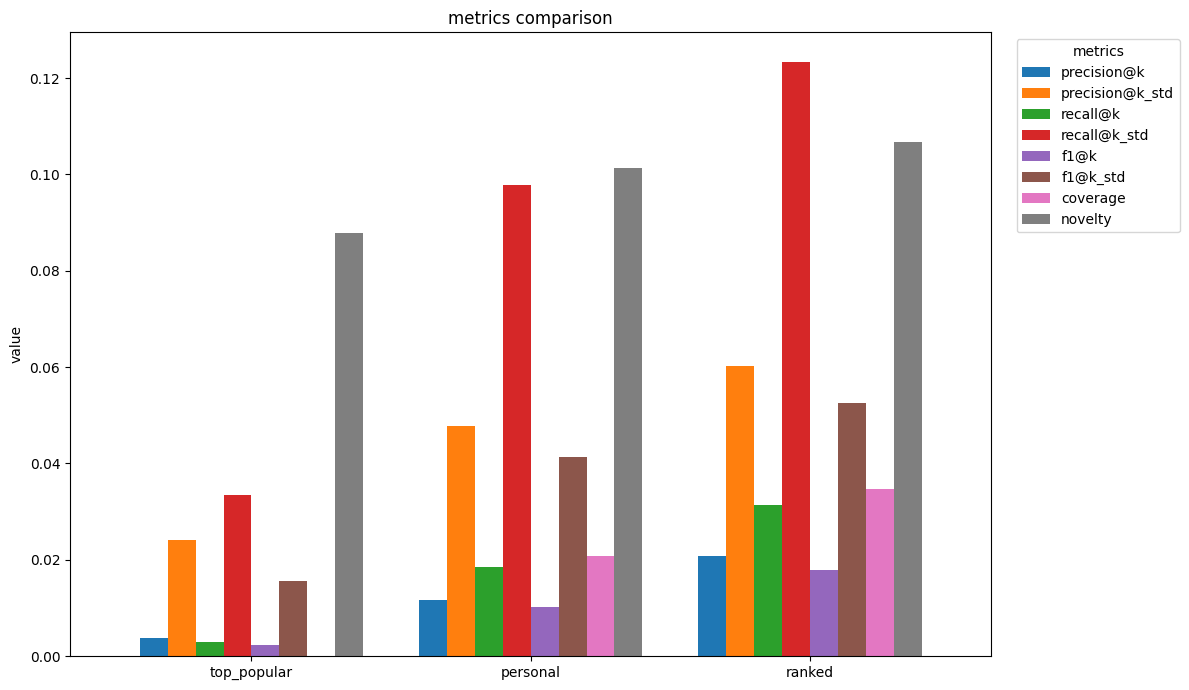

In [ ]:
model_data = {"top_popular": top_popular_sample, "personal": personal_sample, "ranked": ranked_sample}

metrics = {name: calculate_metrics(df, eval_gt_sample, k=CFG.TOP_K) for name, df in model_data.items()}
comparison = pd.DataFrame(metrics).T.reset_index(names="model")

cv_scores = globals().get("cv_scores", [])

metrics_payload = {
    "top_k": int(CFG.TOP_K),
    "split_date": str(CFG.SPLIT_DATE),
    "ranker_cv": {
        "folds": int(len(cv_scores)),
        "scores": [float(x) for x in cv_scores],
        "mean_ndcg": float(np.mean(cv_scores)) if len(cv_scores) else None,
    },
    "models": {name: {k: float(v) for k, v in mm.items()} for name, mm in metrics.items()},
    "comparison_rows": comparison.replace({np.nan: None}).to_dict(orient="records"),
}

with open(CFG.SERVICE_FILES['model_metrics'], "w", encoding="utf-8") as f:
    json.dump(metrics_payload, f, ensure_ascii=False, indent=2)

upload_to_s3(CFG.SERVICE_FILES['model_metrics'], make_s3_key(CFG.S3_RECS_PREFIX, CFG.SERVICE_FILES['model_metrics'].name))
logger.info(f"metrics saved | path={CFG.SERVICE_FILES['model_metrics']} | ram={ram_gb():.2f} gb")

try:
    numeric_cols = comparison.select_dtypes(include=["number"]).columns
    display(comparison.style.format({c: "{:.6f}" for c in numeric_cols}))
except Exception:
    display(comparison)

if not comparison.empty:
    comparison.set_index("model").plot(kind="bar", figsize=(12, 7), rot=0, width=0.8)
    plt.title("metrics comparison")
    plt.ylabel("value")
    plt.xlabel("")
    plt.legend(title="metrics", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Рекомендация на будущее: внедрить кросс-валидацию по времени (time-based CV) для более реалистичной оценки качества и предотвращения утечек данных в признаках.

<div class="alert alert-info" role="alert" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий студента </b>

Спасибо за ревью, поправила утечку в признаках. Теперь все агрегаты для фич считаются строго по events_hist_window на интервале [window_start, cutoff), а events_label отдельно на [cutoff, SPLIT_DATE), так что будущее в признаки попадать не должно (я надеюсь).

</div>


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Хорошая работа! Ты создала полноценный пайплайн рекомендательной системы production-уровня. Я увидел понимание важных аспектов работы с большими данными от эффективного управления памятью через правильные типы данных и ленивую загрузку до алгоритмических оптимизаций с использованием argpartition и битовой упаковки. Отметил правильный баланс между производительностью и читаемостью кода, это похвально. 
    
Единственная существенная проблема - утечка данных при создании признаков. Продолжай в том же духе!